# 參考網站 
+ [微軟的範例](https://github.com/microsoft/ML-For-Beginners/tree/main/7-TimeSeries/2-ARIMA)
+ [ARIMA-GARCH 模型(上)](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8-%E5%8D%81-arima-garch%E6%A8%A1%E5%9E%8B-%E4%B8%8A-4cf07dac75fd)

# 參考網站 
+ [微軟的範例](https://github.com/microsoft/ML-For-Beginners/tree/main/7-TimeSeries/2-ARIMA)
+ [ARIMA-GARCH 模型(上)](https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/%E8%B3%87%E6%96%99%E7%A7%91%E5%AD%B8-%E5%8D%81-arima-garch%E6%A8%A1%E5%9E%8B-%E4%B8%8A-4cf07dac75fd)

# 參數設定

In [1]:
HORIZON = 1 # 0: 預設當日、1: 預測隔日(原本深度學習)，程式寫法僅支援 0,1

predict_types = [5]
fieldName = 'GroupCount'

# predict_types = [1]
# fieldName = 'GroupCount'

# training_window = @training_window@ # 過去天數，用於訓練資料中的歷史資料長度
# predict_type = @predict_type@
# fieldName = '@label_column@' 

# ==== 底下的參數基本上都不要亂動 ====
training_window = 14  # 過去天數，用於訓練資料中的歷史資料長度 
train_split_rate = 0.04  # 訓練集佔整體資料集的比例
# includeTraingData = False  # 資料來源是否包含訓練集最後 14 天，正常要包含，但有少數一些資料會有問題，若遇到有問題，把這個改成 False
 

actFiledName = fieldName 
if HORIZON == 1:
    actFiledName = f'{actFiledName}1'
    
model_dir = 'ARIMA/_Model'

# 定義類別

In [2]:
# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import ArimaLib 
importlib.reload(ArimaLib)   

from ArimaLib import * 
arima = ArimaLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
result_file_name = arima.reset_data(
    model_dir, 
    label_name = fieldName, 
    predicteds = predict_types
)

result_file_name: ARIMA/_Model/GroupCount_data5.result.json


# 載入數據

In [4]:
arima_data = arima.load_data(predict_types)[[fieldName]]
arima_data

# 載入數據


,GroupCount
RequestTime,
2023-04-02,2604
2023-04-03,4036
2023-04-04,3632
2023-04-05,4379
2023-04-06,5613
...,...
2024-04-26,3955
2024-04-27,3299
2024-04-28,2964


# 切割訓練和測試資料集

In [5]:
train_data, test_data = arima.split_train_test_data(arima_data, train_split_rate)
# train_data, test_data = arima.split_train_test_data2(arima_data, training_window=training_window)

# 切割訓練和測試資料集，split rate 0.04
這裡切割訓練和測試跟深度學習不同，這裡只是單純的要切割測試資料集區間，實際上並沒有用到訓練集
data length: 395
train_data.shape: (15, 1)
test_data.shape: (380, 1)


# 原始資料視覺化

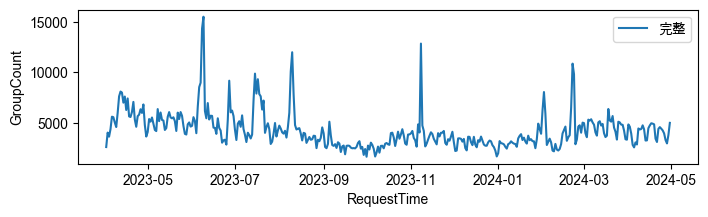

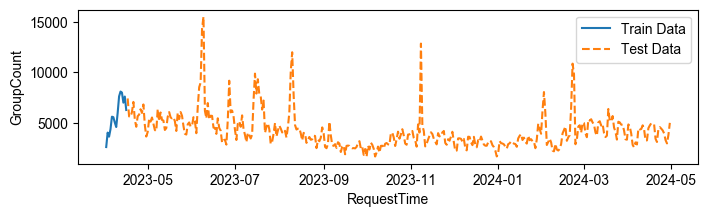

In [6]:
plt.figure(figsize=(8, 2))
plt.plot(arima_data.index, arima_data[fieldName], label='完整')

plt.xlabel('RequestTime')
plt.ylabel(fieldName)
plt.legend()
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(train_data.index, train_data[fieldName], label='Train Data')
plt.plot(test_data.index, test_data[fieldName], label='Test Data', linestyle='--')

plt.xlabel('RequestTime')
plt.ylabel(fieldName)
plt.legend()
plt.show()

# 找出最佳參數

In [7]:
# if includeTraingData:
#     print(f'使用訓練集前 {training_window} 天')
#     aic_data = [x for x in train_data[fieldName]]
#     aic_data = aic_data[(-training_window):] 
#     aic_data.extend(test_data[fieldName].values) 
# else:
#     print(f'不使用訓練集前 {training_window} 天')
#     aic_data = test_data[fieldName].values

aic_data = arima_data[fieldName].values
print(len(aic_data))

auto_model, best_p, best_d, best_q, best_aic, arima_resid, best_ar_pvalue, best_ma_pvalue = \
    arima.find_best_config(aic_data, window_size=training_window)
# 基本上選出來的 P-Vaule 都要小於 0.05，才達到顯著的效果，代表是平穩的序列

395
# 找到最佳的 p, d, q 值，window_size: 14 



Best model:  ARIMA(10,1,14)(0,0,0)[0] intercept
Total fit time: 38.180 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  395
Model:             SARIMAX(10, 1, 14)   Log Likelihood               -3333.458
Date:                Thu, 19 Jun 2025   AIC                           6718.916
Time:                        11:05:07   BIC                           6822.301
Sample:                             0   HQIC                          6759.882
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -20.0057     36.600     -0.547      0.585     -91.740      51.728
ar.L1         -0.1530      0.286     -0.534      0.

# 使用 ARMIA 套件再次驗證

In [8]:
model_summary_fit = arima.check_arima_model(aic_data, best_p, best_d, best_q)

# 檢查 ARIMA 模型


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  395
Model:               ARIMA(10, 1, 14)   Log Likelihood               -3332.197
Date:                Thu, 19 Jun 2025   AIC                           6714.395
Time:                        11:05:08   BIC                           6813.803
Sample:                             0   HQIC                          6753.785
                                - 395                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1881      0.283     -0.664      0.507      -0.744       0.367
ar.L2         -0.0120      0.215     -0.056      0.956      -0.433       0.409
ar.L3          0.4157      0.206      2.019      0.0

# Shift 預測資料

In [9]:
test_shifted = arima.shift_data(test_data, fieldName, HORIZON)
test_shifted.head()
print(len(test_shifted))

# 整理預測未來的資料
380


# 執行預測

In [10]:
test_ts, predictions = arima.predict(
    train_data, test_shifted, 
    field_name=fieldName, 
    act_field_name=actFiledName,
    best_d=best_d,
    best_p=best_p,
    best_q=best_q,
    training_window=training_window,
    horizon=HORIZON
)

# 開始預測
第一個預測日 :  2023-04-17 00:00:00
第一個預測日，前 {training_window} 日數據 :               GroupCount
RequestTime            
2023-04-03         4036
2023-04-04         3632
2023-04-05         4379
2023-04-06         5613
2023-04-07         5562
2023-04-08         5039
2023-04-09         4587
2023-04-10         5981
2023-04-11         7625
2023-04-12         8103
2023-04-13         8006
2023-04-14         7001
2023-04-15         7608
2023-04-16         6278
第一個預測日當日 :  7421.0
第一個預測日隔日 :  5642.0
第一個預測日，前 {training_window} 日數據 :  [2604, 4036, 3632, 4379, 5613, 5562, 5039, 4587, 5981, 7625, 8103, 8006, 7001, 7608, 6278]
最佳的 p 值: 10
最佳的 d 值: 1
最佳的 q 值: 14
-------------------------------------------------------
-------------------------------------------------------

yhat: [6278. 6278.]
( 0). 實際 : 5642.0 預測 : 6278.0 差距 : -636.0
yhat: [7421. 7421.]
( 1). 實際 : 5582.0 預測 : 7421.0 差距 : -1839.0


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


yhat: [ 1298.32072585 40343.42422094]
( 2). 實際 : 6080.0 預測 : 40343.42422093664 差距 : -34263.42422093664
yhat: [7104.38174318  770.50359091]
( 3). 實際 : 7078.0 預測 : 770.5035909136195 差距 : 6307.4964090863805


yhat: [ 2427.47303231 12523.90701818]
( 4). 實際 : 5320.0 預測 : 12523.907018179329 差距 : -7203.907018179329
yhat: [3754.76281817 1177.24767628]
( 5). 實際 : 4615.0 預測 : 1177.2476762845463 差距 : 3437.7523237154537


yhat: [6204.22808722 7592.28186843]
( 6). 實際 : 5662.0 預測 : 7592.281868426168 差距 : -1930.2818684261683
yhat: [8994.38524213 9077.20499068]
( 7). 實際 : 5817.0 預測 : 9077.204990678252 差距 : -3260.204990678252


yhat: [6971.39396118 6504.71840788]
( 8). 實際 : 6350.0 預測 : 6504.7184078843 差距 : -154.71840788430018
yhat: [5944.69122027 3743.82408982]
( 9). 實際 : 5985.0 預測 : 3743.824089820747 差距 : 2241.175910179253


yhat: [3281.76916388 3639.56812115]
(10). 實際 : 6825.0 預測 : 3639.5681211454066 差距 : 3185.4318788545934
yhat: [4688.7599841  5340.23823056]
(11). 實際 : 4782.0 預測 : 5340.23823055581 差距 : -558.2382305558103


yhat: [ 9338.47708781 13463.038018  ]
(12). 實際 : 3643.0 預測 : 13463.0380179976 差距 : -9820.0380179976
yhat: [7903.11680499 7037.38296564]
(13). 實際 : 4095.0 預測 : 7037.382965636086 差距 : -2942.382965636086


yhat: [1774.18419395 1890.94479103]
(14). 實際 : 5380.0 預測 : 1890.944791031331 差距 : 3489.055208968669
yhat: [4845.65120398 3562.64194944]
(15). 實際 : 5122.0 預測 : 3562.6419494363254 差距 : 1559.3580505636746


yhat: [3932.84532479 5103.12795602]
(16). 實際 : 5533.0 預測 : 5103.127956023167 差距 : 429.8720439768331
yhat: [6445.81860363 8751.20808406]
(17). 實際 : 4937.0 預測 : 8751.208084063437 差距 : -3814.208084063437


yhat: [8047.19786544 7457.78155337]
(18). 實際 : 4296.0 預測 : 7457.781553373527 差距 : -3161.7815533735265
yhat: [3789.17952866 3832.39659129]
(19). 實際 : 4187.0 預測 : 3832.3965912940307 差距 : 354.6034087059693


yhat: [4526.9117666  4473.15865968]
(20). 實際 : 6366.0 預測 : 4473.158659684544 差距 : 1892.8413403154564


yhat: [3647.97315128 4652.11210526]
(21). 實際 : 5171.0 預測 : 4652.112105261313 差距 : 518.8878947386866


yhat: [7087.26090461 5922.35425408]
(22). 實際 : 6030.0 預測 : 5922.3542540830895 差距 : 107.64574591691053


yhat: [3830.5866461  3530.50521054]
(23). 實際 : 5293.0 預測 : 3530.5052105377117 差距 : 1762.4947894622883


yhat: [5171.74431297 5590.57939608]
(24). 實際 : 5229.0 預測 : 5590.579396078723 差距 : -361.5793960787232


yhat: [5895.41589684 4472.11066476]
(25). 實際 : 4297.0 預測 : 4472.110664756048 差距 : -175.1106647560482


yhat: [4274.06960368 5402.69578382]
(26). 實際 : 4484.0 預測 : 5402.695783821566 差距 : -918.6957838215658


yhat: [5463.156027   5503.01897299]
(27). 實際 : 5601.0 預測 : 5503.018972994513 差距 : 97.9810270054868


yhat: [4635.93730294 4894.33099542]
(28). 實際 : 6068.0 預測 : 4894.330995421571 差距 : 1173.669004578429


yhat: [5642.87898014 5369.19387294]
(29). 實際 : 5541.0 預測 : 5369.1938729368685 差距 : 171.8061270631315


yhat: [6134.08919269 4603.35889022]
(30). 實際 : 5449.0 預測 : 4603.358890224516 差距 : 845.6411097754844


yhat: [4457.42725707 5259.85347206]
(31). 實際 : 5555.0 預測 : 5259.853472058435 差距 : 295.1465279415652


yhat: [5578.45888252 5177.09190939]
(32). 實際 : 5169.0 預測 : 5177.091909389658 差距 : -8.091909389658213


yhat: [5165.30099732 5129.33632561]
(33). 實際 : 4199.0 預測 : 5129.336325609249 差距 : -930.3363256092489


yhat: [5352.69836053 5906.19012427]
(34). 實際 : 6015.0 預測 : 5906.190124273424 差距 : 108.80987572657614


yhat: [5975.31466538 6032.03633407]
(35). 實際 : 5379.0 預測 : 6032.036334071442 差距 : -653.0363340714421


yhat: [5856.45465675 5773.32309727]
(36). 實際 : 6071.0 預測 : 5773.323097273565 差距 : 297.6769027264354


yhat: [5484.44358251 5259.73844713]
(37). 實際 : 5699.0 預測 : 5259.738447130494 差距 : 439.261552869506


yhat: [ 23649.50734167 235731.14211011]
(38). 實際 : 4686.0 預測 : 235731.14211011233 差距 : -231045.14211011233


yhat: [5643.93616925 4409.42620984]
(39). 實際 : 3913.0 預測 : 4409.426209844677 差距 : -496.42620984467703


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


yhat: [4006.23489283 4653.85210843]
(40). 實際 : 3846.0 預測 : 4653.852108432717 差距 : -807.8521084327167


yhat: [4625.25297483 5742.74352793]
(41). 實際 : 4857.0 預測 : 5742.74352793474 差距 : -885.7435279347401


yhat: [5497.07509848 5953.89749876]
(42). 實際 : 5042.0 預測 : 5953.897498762954 差距 : -911.8974987629535
yhat: [4113.65767645 3667.85271688]
(43). 實際 : 4630.0 預測 : 3667.852716878867 差距 : 962.1472831211331


yhat: [4761.00695295 4956.20621239]
(44). 實際 : 4703.0 預測 : 4956.206212387906 差距 : -253.2062123879059


yhat: [4603.51097083 4535.5640245 ]
(45). 實際 : 5565.0 預測 : 4535.564024497733 差距 : 1029.435975502267
yhat: [3764.15487079 3761.0713713 ]
(46). 實際 : 5188.0 預測 : 3761.071371297768 差距 : 1426.928628702232


yhat: [ 43823.55993201 111015.2030237 ]
(47). 實際 : 3976.0 預測 : 111015.20302369707 差距 : -107039.20302369707
yhat: [3963.70009959 4335.31676458]
(48). 實際 : 6600.0 預測 : 4335.316764581861 差距 : 2264.683235418139


yhat: [5625.65833431 5939.24625852]
(49). 實際 : 8542.0 預測 : 5939.246258519801 差距 : 2602.753741480199


yhat: [6186.18042539 5807.30383347]
(50). 實際 : 8982.0 預測 : 5807.303833472854 差距 : 3174.6961665271456


yhat: [6887.95263171 6155.72158559]
(51). 實際 : 14348.0 預測 : 6155.721585590373 差距 : 8192.278414409626


yhat: [7712.34957334 8828.47034714]
(52). 實際 : 15521.0 預測 : 8828.47034713895 差距 : 6692.529652861051


yhat: [17815.38235842 20647.96839472]
(53). 實際 : 6179.0 預測 : 20647.968394719584 差距 : -14468.968394719584


yhat: [15992.06332657 17239.8400731 ]
(54). 實際 : 5457.0 預測 : 17239.840073104904 差距 : -11782.840073104904


yhat: [ -9077.69295423 -28428.76902748]
(55). 實際 : 6963.0 預測 : -28428.769027482183 差距 : 35391.76902748218


yhat: [9667.40627903 7982.84744171]
(56). 實際 : 5333.0 預測 : 7982.847441709784 差距 : -2649.847441709784


yhat: [2713.06329269 5745.99314531]
(57). 實際 : 5709.0 預測 : 5745.993145311487 差距 : -36.99314531148684


yhat: [ 7171.65012701 12061.75002661]
(58). 實際 : 5693.0 預測 : 12061.750026609294 差距 : -6368.750026609294


yhat: [11069.77155743  4549.43206016]
(59). 實際 : 4526.0 預測 : 4549.432060156332 差距 : -23.432060156332227


yhat: [2585.16667868 -678.20174052]
(60). 實際 : 4505.0 預測 : -678.2017405229703 差距 : 5183.201740522971


yhat: [4745.90057407  226.32856446]
(61). 實際 : 3912.0 預測 : 226.32856445742618 差距 : 3685.671435542574


yhat: [2887.671589   2801.25532412]
(62). 實際 : 5453.0 預測 : 2801.255324117575 差距 : 2651.744675882425


yhat: [5456.46229051 5078.55757433]
(63). 實際 : 4499.0 預測 : 5078.557574330833 差距 : -579.5575743308327


yhat: [9883.94936478 9337.62734353]
(64). 實際 : 4237.0 預測 : 9337.627343533679 差距 : -5100.627343533679


yhat: [3199.80156997 7350.44361714]
(65). 實際 : 3036.0 預測 : 7350.443617139316 差距 : -4314.443617139316


yhat: [ 8192.74778554 10186.03530062]
(66). 實際 : 3267.0 預測 : 10186.03530062475 差距 : -6919.03530062475


yhat: [6532.54521208 3311.33742911]
(67). 實際 : 3332.0 預測 : 3311.3374291087302 差距 : 20.662570891269752


yhat: [ 607.68357283 1090.62629294]
(68). 實際 : 2845.0 預測 : 1090.6262929440259 差距 : 1754.3737070559741


yhat: [3730.12294992 6509.00477124]
(69). 實際 : 5333.0 預測 : 6509.004771239379 差距 : -1176.004771239379


yhat: [5727.50556671 6123.49321411]
(70). 實際 : 9180.0 預測 : 6123.4932141073205 差距 : 3056.5067858926795


yhat: [5749.33847231 4229.29557772]
(71). 實際 : 6042.0 預測 : 4229.29557772493 差距 : 1812.70442227507


yhat: [6816.85442662 7374.36570554]
(72). 實際 : 6218.0 預測 : 7374.365705539916 差距 : -1156.3657055399162


yhat: [6088.28488123 8712.51420331]
(73). 實際 : 5676.0 預測 : 8712.514203307946 差距 : -3036.5142033079464


yhat: [8225.55628029 4204.19053686]
(74). 實際 : 4316.0 預測 : 4204.190536861164 差距 : 111.80946313883578


yhat: [3190.56340949 3303.30520351]
(75). 實際 : 3303.0 預測 : 3303.3052035088926 差距 : -0.3052035088926459


yhat: [4559.95560055 6573.82541205]
(76). 實際 : 4919.0 預測 : 6573.825412046795 差距 : -1654.8254120467946


yhat: [5301.47472426 5877.13171475]
(77). 實際 : 5163.0 預測 : 5877.13171474871 差距 : -714.1317147487098


yhat: [5538.03454359 5154.31398799]
(78). 實際 : 4610.0 預測 : 5154.313987992413 差距 : -544.3139879924129


yhat: [4811.75082729 4835.35186771]
(79). 實際 : 5743.0 預測 : 4835.351867710145 差距 : 907.6481322898553


yhat: [4646.08905923 5715.80487595]
(80). 實際 : 4380.0 預測 : 5715.804875949351 差距 : -1335.8048759493513


yhat: [6736.41083822 4981.66811123]
(81). 實際 : 3811.0 預測 : 4981.668111226402 差距 : -1170.6681112264023


yhat: [2636.59402895 3566.53291985]
(82). 實際 : 3098.0 預測 : 3566.532919848722 差距 : -468.53291984872203


yhat: [4413.49468969 4972.46619736]
(83). 實際 : 4023.0 預測 : 4972.466197360947 差距 : -949.4661973609473


yhat: [4241.29571721 5856.03981541]
(84). 實際 : 3792.0 預測 : 5856.039815406342 差距 : -2064.0398154063423


yhat: [5656.95173101 5108.26440657]
(85). 實際 : 3453.0 預測 : 5108.2644065741515 差距 : -1655.2644065741515


yhat: [4005.94220037 4568.93879326]
(86). 實際 : 3842.0 預測 : 4568.938793262448 差距 : -726.9387932624477


yhat: [4199.2170702  5165.12589547]
(87). 實際 : 7253.0 預測 : 5165.125895465733 差距 : 2087.8741045342667


yhat: [4711.23742051 4016.85845402]
(88). 實際 : 9882.0 預測 : 4016.858454016207 差距 : 5865.141545983794


yhat: [6102.70172518 5344.40989829]
(89). 實際 : 7905.0 預測 : 5344.409898286053 差距 : 2560.5901017139468


yhat: [8446.49243425 8534.45658248]
(90). 實際 : 9327.0 預測 : 8534.456582481376 差距 : 792.5434175186238


yhat: [8082.16299979 8555.52711519]
(91). 實際 : 7857.0 預測 : 8555.52711519437 差距 : -698.5271151943707


yhat: [9706.89331879 6753.97624024]
(92). 實際 : 7634.0 預測 : 6753.976240238675 差距 : 880.023759761325


yhat: [5165.23377303 6085.26394901]
(93). 實際 : 6319.0 預測 : 6085.263949014261 差距 : 233.73605098573898


yhat: [8468.1047295  8526.04797748]
(94). 實際 : 7211.0 預測 : 8526.047977475382 差距 : -1315.0479774753821


yhat: [6942.74527443 5610.51612603]
(95). 實際 : 4012.0 預測 : 5610.516126032404 差距 : -1598.516126032404


yhat: [5566.66792587 4178.32246613]
(96). 實際 : 4590.0 預測 : 4178.322466125045 差距 : 411.67753387495486


yhat: [2995.79442919 4271.11478081]
(97). 實際 : 4962.0 預測 : 4271.114780807213 差距 : 690.8852191927872


yhat: [5429.68403355 5510.2751989 ]
(98). 實際 : 4384.0 預測 : 5510.275198897503 差距 : -1126.2751988975033


yhat: [5145.05174593 4269.26049736]
(99). 實際 : 2909.0 預測 : 4269.260497363736 差距 : -1360.2604973637362


yhat: [3446.3251237 4194.4696249]
(100). 實際 : 3136.0 預測 : 4194.469624902116 差距 : -1058.4696249021163


yhat: [4019.99098066 4229.68958968]
(101). 實際 : 3932.0 預測 : 4229.689589683068 差距 : -297.68958968306833


yhat: [3790.17099541 4022.55565835]
(102). 實際 : 4986.0 預測 : 4022.5556583548746 差距 : 963.4443416451254


yhat: [3646.67465177 3964.40206854]
(103). 實際 : 3647.0 預測 : 3964.40206854084 差距 : -317.40206854084


yhat: [4883.88577335 5684.00545842]
(104). 實際 : 4235.0 預測 : 5684.005458420477 差距 : -1449.0054584204772


yhat: [4914.90869024 5805.94393087]
(105). 實際 : 4727.0 預測 : 5805.943930874381 差距 : -1078.9439308743813


yhat: [5311.82627079 5205.36008682]
(106). 實際 : 4441.0 預測 : 5205.360086821954 差距 : -764.3600868219537


yhat: [4807.33244475 5003.76024663]
(107). 實際 : 4061.0 預測 : 5003.7602466346125 差距 : -942.7602466346125


yhat: [4840.29641032 7205.16433072]
(108). 實際 : 3931.0 預測 : 7205.164330719783 差距 : -3274.164330719783


yhat: [6453.6657372  5801.85660477]
(109). 實際 : 4212.0 預測 : 5801.8566047685235 差距 : -1589.8566047685235


yhat: [3948.88926379 3737.39788427]
(110). 實際 : 3542.0 預測 : 3737.3978842650295 差距 : -195.39788426502946


yhat: [3927.82518915 5787.00800129]
(111). 實際 : 4579.0 預測 : 5787.008001289578 差距 : -1208.0080012895778


yhat: [5414.43427314 5882.95923596]
(112). 實際 : 6003.0 預測 : 5882.959235961475 差距 : 120.04076403852469


yhat: [5167.37335945 4451.70564774]
(113). 實際 : 10091.0 預測 : 4451.7056477370215 差距 : 5639.2943522629785


yhat: [5182.86744108 5335.34242356]
(114). 實際 : 12000.0 預測 : 5335.342423562447 差距 : 6664.657576437553


yhat: [9601.02970121 8839.52027117]
(115). 實際 : 7825.0 預測 : 8839.520271167416 差距 : -1014.5202711674156


yhat: [11129.64043319  8880.33579226]
(116). 實際 : 4781.0 預測 : 8880.335792262 差距 : -4099.335792262


yhat: [5567.83485621 5055.12844027]
(117). 實際 : 4340.0 預測 : 5055.128440271672 差距 : -715.1284402716719


yhat: [4365.04839107 4296.5545011 ]
(118). 實際 : 4430.0 預測 : 4296.55450109811 差距 : 133.44549890188955


yhat: [4288.79880225 4499.21802919]
(119). 實際 : 4475.0 預測 : 4499.218029190843 差距 : -24.21802919084257


yhat: [4638.09601251 5262.67096477]
(120). 實際 : 3956.0 預測 : 5262.670964769232 差距 : -1306.6709647692323


yhat: [5071.1119163  4764.25993851]
(121). 實際 : 3258.0 預測 : 4764.259938510145 差距 : -1506.2599385101448


yhat: [3752.71793367 3691.00773489]
(122). 實際 : 4013.0 預測 : 3691.007734890422 差距 : 321.99226510957806


yhat: [3276.28661742 3249.07011899]
(123). 實際 : 3943.0 預測 : 3249.070118986724 差距 : 693.9298810132759


yhat: [3853.39160981 3885.95918496]
(124). 實際 : 3017.0 預測 : 3885.9591849561375 差距 : -868.9591849561375


yhat: [3889.17066776 4787.74529898]
(125). 實際 : 3310.0 預測 : 4787.745298984506 差距 : -1477.745298984506


yhat: [4005.86668796 4837.57712707]
(126). 實際 : 3601.0 預測 : 4837.57712707056 差距 : -1236.57712707056


yhat: [4283.38063943 4284.00685284]
(127). 實際 : 3327.0 預測 : 4284.0068528361835 差距 : -957.0068528361835


yhat: [3807.17586257 5351.10346927]
(128). 實際 : 3369.0 預測 : 5351.103469272701 差距 : -1982.1034692727007


yhat: [5008.85956101 5923.2791368 ]
(129). 實際 : 3725.0 預測 : 5923.27913679864 差距 : -2198.27913679864


yhat: [4446.1647638  4203.64532043]
(130). 實際 : 3701.0 預測 : 4203.645320425974 差距 : -502.6453204259742


yhat: [3581.42849314 4893.04349011]
(131). 實際 : 2498.0 預測 : 4893.043490106016 差距 : -2395.043490106016


yhat: [4967.19728462 6179.21087878]
(132). 實際 : 3327.0 預測 : 6179.21087877572 差距 : -2852.2108787757197


yhat: [4026.50559646 4531.99212557]
(133). 實際 : 3182.0 預測 : 4531.992125567998 差距 : -1349.9921255679983


yhat: [3952.4847742  4946.45743287]
(134). 實際 : 3524.0 預測 : 4946.457432873011 差距 : -1422.4574328730114


yhat: [4268.03566491 5446.33695571]
(135). 實際 : 4554.0 預測 : 5446.336955708461 差距 : -892.3369557084607


yhat: [4714.31643812 4793.38077314]
(136). 實際 : 3964.0 預測 : 4793.380773137226 差距 : -829.3807731372262


yhat: [4620.85672222 4320.54207692]
(137). 實際 : 2612.0 預測 : 4320.542076915342 差距 : -1708.5420769153416


yhat: [3749.59752109 4223.57401188]
(138). 實際 : 2490.0 預測 : 4223.574011879071 差距 : -1733.574011879071


yhat: [3317.81919627 3896.24936333]
(139). 實際 : 2915.0 預測 : 3896.2493633296026 差距 : -981.2493633296026


yhat: [3194.96560433 3789.6869347 ]
(140). 實際 : 5115.0 預測 : 3789.6869346999597 差距 : 1325.3130653000403


yhat: [3444.5745044 4188.4796618]
(141). 實際 : 3768.0 預測 : 4188.47966179707 差距 : -420.47966179706964


yhat: [5621.50096651 5631.48067644]
(142). 實際 : 2798.0 預測 : 5631.4806764404775 差距 : -2833.4806764404775


yhat: [3790.07289964 4578.57523067]
(143). 實際 : 2722.0 預測 : 4578.575230673485 差距 : -1856.5752306734848


yhat: [3787.79310011 4340.26331934]
(144). 實際 : 2891.0 預測 : 4340.263319341509 差距 : -1449.2633193415086


yhat: [3313.86927893 3326.2095375 ]
(145). 實際 : 2516.0 預測 : 3326.2095375002805 差距 : -810.2095375002805


yhat: [2970.03440094 4483.27255214]
(146). 實際 : 3079.0 預測 : 4483.272552139782 差距 : -1404.2725521397824


yhat: [4148.17896987 4641.5506783 ]
(147). 實際 : 2948.0 預測 : 4641.550678295239 差距 : -1693.5506782952389


yhat: [3829.9517754  4140.12539685]
(148). 實際 : 2114.0 預測 : 4140.125396846226 差距 : -2026.125396846226


yhat: [3361.25068869 4415.52880397]
(149). 實際 : 2663.0 預測 : 4415.528803969052 差距 : -1752.5288039690522


yhat: [3051.82720482 4375.09586575]
(150). 實際 : 2754.0 預測 : 4375.095865754371 差距 : -1621.0958657543706


yhat: [4016.52432569 3841.31318595]
(151). 實際 : 1888.0 預測 : 3841.313185947235 差距 : -1953.313185947235


yhat: [2616.53557591 3365.55953578]
(152). 實際 : 2723.0 預測 : 3365.559535784549 差距 : -642.5595357845491


yhat: [2629.95711866 3333.16232778]
(153). 實際 : 2747.0 預測 : 3333.162327784093 差距 : -586.1623277840931


yhat: [3467.30473602 3458.84517759]
(154). 實際 : 2725.0 預測 : 3458.8451775909048 差距 : -733.8451775909048


yhat: [2909.84773866 3037.17375147]
(155). 實際 : 2548.0 預測 : 3037.1737514740657 差距 : -489.17375147406574


yhat: [2807.33071087 3232.01591366]
(156). 實際 : 2481.0 預測 : 3232.015913659082 差距 : -751.0159136590819


yhat: [2926.65727101 2812.1033815 ]
(157). 實際 : 2500.0 預測 : 2812.103381495408 差距 : -312.10338149540803


yhat: [2455.1622415  2769.71405854]
(158). 實際 : 2473.0 預測 : 2769.71405854109 差距 : -296.7140585410898


yhat: [2813.22487216 2511.43664325]
(159). 實際 : 2617.0 預測 : 2511.4366432514234 差距 : 105.56335674857655


yhat: [2192.6233002 2731.2627952]
(160). 實際 : 3007.0 預測 : 2731.2627952025337 差距 : 275.73720479746635


yhat: [3127.74267851 3407.75831314]
(161). 實際 : 3184.0 預測 : 3407.758313135574 差距 : -223.7583131355741


yhat: [3329.87595089 3145.16797906]
(162). 實際 : 2448.0 預測 : 3145.167979061889 差距 : -697.1679790618891


yhat: [2975.78432575 3003.4988093 ]
(163). 實際 : 2615.0 預測 : 3003.498809296127 差距 : -388.4988092961271


yhat: [2473.75296598 3531.30781436]
(164). 實際 : 1824.0 預測 : 3531.307814357914 差距 : -1707.3078143579141


yhat: [3654.38331947 3293.61349138]
(165). 實際 : 2410.0 預測 : 3293.613491377608 差距 : -883.6134913776082


yhat: [1560.05430113 2175.29078808]
(166). 實際 : 1645.0 預測 : 2175.2907880814155 差距 : -530.2907880814155


yhat: [3020.83980125 3938.45588325]
(167). 實際 : 2752.0 預測 : 3938.455883252726 差距 : -1186.455883252726


yhat: [2632.17527702 3007.91426655]
(168). 實際 : 2357.0 預測 : 3007.914266553692 差距 : -650.914266553692


yhat: [3015.97884261 2877.46592233]
(169). 實際 : 3039.0 預測 : 2877.4659223341873 差距 : 161.53407766581267


yhat: [2426.65211948 2995.9257389 ]
(170). 實際 : 2821.0 預測 : 2995.925738897471 差距 : -174.9257388974711


yhat: [3565.5915848  3674.21644127]
(171). 實際 : 2435.0 預測 : 3674.216441272033 差距 : -1239.216441272033


yhat: [2968.05372285 2601.545664  ]
(172). 實際 : 1666.0 預測 : 2601.5456640007874 差距 : -935.5456640007874


yhat: [2050.55962793 2538.4203494 ]
(173). 實際 : 2064.0 預測 : 2538.420349401211 差距 : -474.42034940121084


yhat: [2195.80427086 2205.38783846]
(174). 實際 : 2651.0 預測 : 2205.387838457492 差距 : 445.61216154250815


yhat: [2097.69882363 2182.84320825]
(175). 實際 : 2047.0 預測 : 2182.8432082476884 差距 : -135.84320824768838


yhat: [2755.39517167 2456.19871819]
(176). 實際 : 2718.0 預測 : 2456.198718189432 差距 : 261.80128181056807


yhat: [1900.94657419 2048.52652037]
(177). 實際 : 2733.0 預測 : 2048.526520370288 差距 : 684.4734796297121


yhat: [2874.97635957 3089.25827861]
(178). 實際 : 2479.0 預測 : 3089.2582786105054 差距 : -610.2582786105054


yhat: [2901.47174482 2716.29431479]
(179). 實際 : 2934.0 預測 : 2716.2943147897977 差距 : 217.70568521020232


yhat: [2317.6520306  2447.81723735]
(180). 實際 : 3002.0 預測 : 2447.8172373470165 差距 : 554.1827626529835


yhat: [3103.40090246 3361.35654593]
(181). 實際 : 2873.0 預測 : 3361.3565459332854 差距 : -488.35654593328536


yhat: [3256.92195534 3333.16861341]
(182). 實際 : 2822.0 預測 : 3333.1686134087695 差距 : -511.1686134087695


yhat: [2989.27607962 2891.72488981]
(183). 實際 : 3988.0 預測 : 2891.7248898130083 差距 : 1096.2751101869917


yhat: [2730.54338658 3216.48925209]
(184). 實際 : 4027.0 預測 : 3216.4892520944413 差距 : 810.5107479055587


yhat: [4452.18234988 4251.75503724]
(185). 實際 : 3556.0 預測 : 4251.75503724231 差距 : -695.7550372423102


yhat: [3837.02609715 3334.46782618]
(186). 實際 : 2707.0 預測 : 3334.4678261820154 差距 : -627.4678261820154


yhat: [3085.31936487 3186.21256305]
(187). 實際 : 3383.0 預測 : 3186.212563052421 差距 : 196.78743694757895


yhat: [2832.99466322 2994.06511592]
(188). 實際 : 4128.0 預測 : 2994.0651159177696 差距 : 1133.9348840822304


yhat: [3477.16163852 2969.40419214]
(189). 實際 : 3432.0 預測 : 2969.4041921352823 差距 : 462.5958078647177


yhat: [3591.01573795 3305.94647152]
(190). 實際 : 3853.0 預測 : 3305.9464715165423 差距 : 547.0535284834577


yhat: [3177.43481199 3246.21733809]
(191). 實際 : 4373.0 預測 : 3246.2173380930876 差距 : 1126.7826619069124


yhat: [3865.97135426 3346.60065283]
(192). 實際 : 3761.0 預測 : 3346.600652832556 差距 : 414.3993471674439


yhat: [3839.73616811 3019.07468905]
(193). 實際 : 2950.0 預測 : 3019.0746890516793 差距 : -69.07468905167934


yhat: [2953.442871   2914.47755837]
(194). 實際 : 2832.0 預測 : 2914.477558369221 差距 : -82.47755836922079


yhat: [2927.93036566 2876.822242  ]
(195). 實際 : 3843.0 預測 : 2876.8222420020784 差距 : 966.1777579979216


yhat: [2807.15268046 2699.20450579]
(196). 實際 : 3856.0 預測 : 2699.204505790434 差距 : 1156.7954942095662


yhat: [3722.22766729 3477.87348186]
(197). 實際 : 3954.0 預測 : 3477.8734818593716 差距 : 476.1265181406284


yhat: [3630.36315766 3825.59795852]
(198). 實際 : 4199.0 預測 : 3825.5979585195296 差距 : 373.4020414804704


yhat: [4139.36045952 3971.13159752]
(199). 實際 : 3507.0 預測 : 3971.131597520668 差距 : -464.13159752066804


yhat: [4030.94557067 3517.99151791]
(200). 實際 : 3272.0 預測 : 3517.9915179075642 差距 : -245.99151790756423


yhat: [3056.10732423 3170.43535992]
(201). 實際 : 2644.0 預測 : 3170.4353599231035 差距 : -526.4353599231035


yhat: [3414.55742984 3817.3304576 ]
(202). 實際 : 4847.0 預測 : 3817.3304575999387 差距 : 1029.6695424000613


yhat: [3135.03139023 3053.33524492]
(203). 實際 : 4046.0 預測 : 3053.3352449242407 差距 : 992.6647550757593


yhat: [4661.83167463 4259.26987646]
(204). 實際 : 12859.0 預測 : 4259.269876455296 差距 : 8599.730123544705


yhat: [3694.2801418  3817.07833019]
(205). 實際 : 4739.0 預測 : 3817.078330191291 差距 : 921.9216698087089


yhat: [11559.75541677  9669.63424109]
(206). 實際 : 4204.0 預測 : 9669.634241087571 差距 : -5465.634241087571


yhat: [5414.68215545 2475.40297441]
(207). 實際 : 2665.0 預測 : 2475.4029744142726 差距 : 189.59702558572735


yhat: [1961.53568018 4095.05654636]
(208). 實際 : 2938.0 預測 : 4095.0565463608846 差距 : -1157.0565463608846


yhat: [4362.05124851 2940.76369919]
(209). 實際 : 3351.0 預測 : 2940.763699194238 差距 : 410.23630080576186


yhat: [2182.25375829 3521.75887604]
(210). 實際 : 3730.0 預測 : 3521.758876035526 差距 : 208.2411239644739


yhat: [4209.03130825 4108.46990617]
(211). 實際 : 4065.0 預測 : 4108.469906169412 差距 : -43.46990616941184


yhat: [3869.77643903 3363.03989239]
(212). 實際 : 3894.0 預測 : 3363.0398923870357 差距 : 530.9601076129643


yhat: [3507.78153724 4080.2457726 ]
(213). 實際 : 3420.0 預測 : 4080.2457725994095 差距 : -660.2457725994095


yhat: [4390.39708274 2669.09008519]
(214). 實際 : 3156.0 預測 : 2669.0900851944907 差距 : 486.9099148055093


yhat: [3163.1482832  2253.51008403]
(215). 實際 : 2870.0 預測 : 2253.5100840287696 差距 : 616.4899159712304


yhat: [2386.50439336 4076.9888797 ]
(216). 實際 : 3982.0 預測 : 4076.988879699961 差距 : -94.98887969996122


yhat: [4353.60498078 3372.13524799]
(217). 實際 : 3655.0 預測 : 3372.1352479939337 差距 : 282.8647520060663


yhat: [3239.27795995 3324.40678312]
(218). 實際 : 4019.0 預測 : 3324.406783121453 差距 : 694.5932168785471


yhat: [3531.31731798 4591.9380939 ]
(219). 實際 : 4022.0 預測 : 4591.938093899798 差距 : -569.9380938997983


yhat: [4928.18159936 3568.01315241]
(220). 實際 : 4199.0 預測 : 3568.0131524127473 差距 : 630.9868475872527


yhat: [3014.76647401 3001.2663132 ]
(221). 實際 : 3011.0 預測 : 3001.266313197342 差距 : 9.733686802658212


yhat: [3707.05912483 4697.36121147]
(222). 實際 : 2833.0 預測 : 4697.361211473095 差距 : -1864.361211473095


yhat: [4299.00531611 4379.88995376]
(223). 實際 : 3381.0 預測 : 4379.88995376188 差距 : -998.88995376188


yhat: [3881.70270345 3184.97829853]
(224). 實際 : 3234.0 預測 : 3184.9782985323764 差距 : 49.02170146762364


yhat: [2821.35813366 4120.5880537 ]
(225). 實際 : 3646.0 預測 : 4120.588053696712 差距 : -474.58805369671245


yhat: [4353.18982283 3888.25792383]
(226). 實際 : 4118.0 預測 : 3888.257923831772 差距 : 229.74207616822787


yhat: [3634.73266864 3176.41985571]
(227). 實際 : 3096.0 預測 : 3176.4198557122604 差距 : -80.41985571226041


yhat: [3553.54453531 3567.77432328]
(228). 實際 : 2211.0 預測 : 3567.774323279769 差距 : -1356.7743232797689


yhat: [3340.23059309 3707.08160154]
(229). 實際 : 2254.0 預測 : 3707.0816015407186 差距 : -1453.0816015407186


yhat: [3005.80922862 3224.98119131]
(230). 實際 : 3461.0 預測 : 3224.9811913070203 差距 : 236.01880869297975


yhat: [2747.53277646 2384.58876389]
(231). 實際 : 3466.0 預測 : 2384.5887638866793 差距 : 1081.4112361133207


yhat: [2883.05059884 3135.97096014]
(232). 實際 : 3419.0 預測 : 3135.9709601403247 差距 : 283.0290398596753


yhat: [3405.51521964 3383.68944566]
(233). 實際 : 3140.0 預測 : 3383.6894456640803 差距 : -243.68944566408027


yhat: [3476.02728242 3237.18893281]
(234). 實際 : 3409.0 預測 : 3237.1889328086995 差距 : 171.81106719130048


yhat: [2967.63140779 2939.59196145]
(235). 實際 : 2505.0 預測 : 2939.591961451134 差距 : -434.591961451134


yhat: [3232.02594366 3723.16526979]
(236). 實際 : 2273.0 預測 : 3723.16526979485 差距 : -1450.1652697948498


yhat: [3296.26742719 3163.44371293]
(237). 實際 : 3629.0 預測 : 3163.4437129341068 差距 : 465.55628706589323


yhat: [2554.20911443 2556.55244964]
(238). 實際 : 3609.0 預測 : 2556.552449641381 差距 : 1052.447550358619


yhat: [3254.30317688 3694.68774601]
(239). 實際 : 3086.0 預測 : 3694.6877460149317 差距 : -608.6877460149317


yhat: [3925.08942294 4151.98335703]
(240). 實際 : 2793.0 預測 : 4151.983357029493 差距 : -1358.9833570294932


yhat: [3645.01614851 3709.06265372]
(241). 實際 : 3620.0 預測 : 3709.0626537240123 差距 : -89.0626537240123


yhat: [3220.55781669 3119.73550959]
(242). 實際 : 2840.0 預測 : 3119.7355095939993 差距 : -279.73550959399927


yhat: [3352.45176304 3795.04668288]
(243). 實際 : 2582.0 預測 : 3795.0466828826425 差距 : -1213.0466828826425


yhat: [3461.96556459 3316.19923601]
(244). 實際 : 3283.0 預測 : 3316.199236009838 差距 : -33.19923600983793


yhat: [2762.76425582 2881.44453936]
(245). 實際 : 3134.0 預測 : 2881.4445393618353 差距 : 252.55546063816473


yhat: [3204.40526105 3388.24422444]
(246). 實際 : 3642.0 預測 : 3388.244224436579 差距 : 253.75577556342114


yhat: [3307.99915285 3545.97736156]
(247). 實際 : 3250.0 預測 : 3545.9773615594904 差距 : -295.9773615594904


yhat: [3741.86040091 3374.87741207]
(248). 實際 : 2854.0 預測 : 3374.877412073242 差距 : -520.8774120732419


yhat: [3085.78066851 2571.00594558]
(249). 實際 : 2739.0 預測 : 2571.005945579909 差距 : 167.99405442009083


yhat: [2425.57600515 2721.31869035]
(250). 實際 : 2735.0 預測 : 2721.318690351263 差距 : 13.68130964873717


yhat: [2937.90056289 2808.2665843 ]
(251). 實際 : 3070.0 預測 : 2808.2665842975525 差距 : 261.7334157024475


yhat: [2689.90239803 2828.78131996]
(252). 實際 : 3248.0 預測 : 2828.7813199640455 差距 : 419.21868003595455


yhat: [3103.8834083  3239.45138082]
(253). 實際 : 3170.0 預測 : 3239.4513808152274 差距 : -69.45138081522737


yhat: [3313.62717716 3378.0195163 ]
(254). 實際 : 2786.0 預測 : 3378.019516301128 差距 : -592.0195163011281


yhat: [3286.63681872 3054.8832585 ]
(255). 實際 : 2600.0 預測 : 3054.8832585018763 差距 : -454.8832585018763


yhat: [2719.72712508 2754.06117817]
(256). 實際 : 2256.0 預測 : 2754.061178167792 差距 : -498.06117816779215


yhat: [2672.40623746 3007.91954255]
(257). 實際 : 1673.0 預測 : 3007.91954255156 差距 : -1334.91954255156


yhat: [2734.9360146  3205.31847795]
(258). 實際 : 1988.0 預測 : 3205.3184779467974 差距 : -1217.3184779467974


yhat: [2534.78566096 3022.80773461]
(259). 實際 : 3193.0 預測 : 3022.8077346149844 差距 : 170.19226538501562


yhat: [2619.32321779 2837.96812986]
(260). 實際 : 2991.0 預測 : 2837.968129864824 差距 : 153.03187013517618


yhat: [3203.23343848 3432.10109725]
(261). 實際 : 2953.0 預測 : 3432.101097252117 差距 : -479.10109725211714


yhat: [3278.9386046  2978.80716412]
(262). 實際 : 2873.0 預測 : 2978.807164118259 差距 : -105.80716411825915


yhat: [2805.90317806 2701.42743897]
(263). 實際 : 2627.0 預測 : 2701.427438972033 差距 : -74.42743897203309


yhat: [2745.33953498 2883.73299424]
(264). 實際 : 2447.0 預測 : 2883.7329942422507 差距 : -436.7329942422507


yhat: [2838.05411657 3064.66871153]
(265). 實際 : 2892.0 預測 : 3064.668711527828 差距 : -172.66871152782778


yhat: [2833.26996305 2587.9882738 ]
(266). 實際 : 2974.0 預測 : 2587.988273803692 差距 : 386.0117261963078


yhat: [2645.07774241 2579.24574361]
(267). 實際 : 3173.0 預測 : 2579.245743610112 差距 : 593.7542563898878


yhat: [2788.13445627 2861.4872284 ]
(268). 實際 : 3032.0 預測 : 2861.487228397172 差距 : 170.5127716028278


yhat: [3148.82883392 2854.46821865]
(269). 實際 : 2942.0 預測 : 2854.4682186502805 差距 : 87.5317813497195


yhat: [2768.65698967 2705.2363474 ]
(270). 實際 : 2902.0 預測 : 2705.236347399062 差距 : 196.7636526009378


yhat: [2810.02782414 3024.41302941]
(271). 實際 : 2627.0 預測 : 3024.4130294057563 差距 : -397.41302940575633


yhat: [3081.19149383 3071.5821215 ]
(272). 實際 : 3460.0 預測 : 3071.582121501592 差距 : 388.41787849840784


yhat: [2802.88506022 2707.54279127]
(273). 實際 : 3717.0 預測 : 2707.542791271096 差距 : 1009.4572087289039


yhat: [3180.02571019 3218.63798411]
(274). 實際 : 3880.0 預測 : 3218.6379841130765 差距 : 661.3620158869235


yhat: [3588.26028793 3494.17938952]
(275). 實際 : 3299.0 預測 : 3494.1793895157357 差距 : -195.1793895157357


yhat: [3694.46628539 3586.11291418]
(276). 實際 : 3536.0 預測 : 3586.112914175155 差距 : -50.112914175154856


yhat: [3358.09815649 3265.27736615]
(277). 實際 : 3149.0 預測 : 3265.277366150488 差距 : -116.27736615048798


yhat: [3375.42888288 3357.70389083]
(278). 實際 : 2946.0 預測 : 3357.7038908278346 差距 : -411.7038908278346


yhat: [3222.75238272 3296.22378145]
(279). 實際 : 3731.0 預測 : 3296.2237814519913 差距 : 434.7762185480087


yhat: [3119.3414126  3053.85403067]
(280). 實際 : 3283.0 預測 : 3053.8540306681207 差距 : 229.14596933187931


yhat: [3478.88193893 3346.44719591]
(281). 實際 : 3381.0 預測 : 3346.4471959140337 差距 : 34.55280408596627


yhat: [3205.83321139 3297.44865478]
(282). 實際 : 3182.0 預測 : 3297.448654780231 差距 : -115.44865478023121


yhat: [3397.03053786 3249.41950748]
(283). 實際 : 3176.0 預測 : 3249.4195074791937 差距 : -73.41950747919373


yhat: [3106.75522798 2778.15749679]
(284). 實際 : 2489.0 預測 : 2778.157496790005 差距 : -289.1574967900051


yhat: [2812.65488116 2794.14319483]
(285). 實際 : 3376.0 預測 : 2794.143194833772 差距 : 581.8568051662278


yhat: [2661.70526257 2712.21741916]
(286). 實際 : 4926.0 預測 : 2712.217419156765 差距 : 2213.782580843235


yhat: [3160.51525443 3022.93036283]
(287). 實際 : 4396.0 預測 : 3022.9303628299867 差距 : 1373.0696371700133


yhat: [4187.2223645  3922.46688926]
(288). 實際 : 3919.0 預測 : 3922.466889262041 差距 : -3.4668892620411498


yhat: [4062.70508756 3720.16845846]
(289). 實際 : 6239.0 預測 : 3720.168458460603 差距 : 2518.831541539397


yhat: [3628.40271034 3295.30990287]
(290). 實際 : 8056.0 預測 : 3295.3099028735955 差距 : 4760.690097126404


yhat: [5031.70241799 4418.27929434]
(291). 實際 : 5923.0 預測 : 4418.279294340938 差距 : 1504.7207056590623


yhat: [6450.64827032 5435.01240858]
(292). 實際 : 2807.0 預測 : 5435.012408579212 差距 : -2628.012408579212


yhat: [5094.29091843 4635.45246302]
(293). 實際 : 3119.0 預測 : 4635.452463020041 差距 : -1516.4524630200413


yhat: [3154.94364529 3507.29118052]
(294). 實際 : 3434.0 預測 : 3507.291180519578 差距 : -73.29118051957812


yhat: [3473.54247159 3982.97489298]
(295). 實際 : 3070.0 預測 : 3982.97489297623 差距 : -912.97489297623


yhat: [3935.59646053 4062.59335514]
(296). 實際 : 2250.0 預測 : 4062.5933551406597 差距 : -1812.5933551406597


yhat: [3465.81546309 3763.20927867]
(297). 實際 : 2178.0 預測 : 3763.2092786724793 差距 : -1585.2092786724793


yhat: [2880.37085765 3220.92991894]
(298). 實際 : 2917.0 預測 : 3220.9299189437847 差距 : -303.92991894378474


yhat: [2774.03359068 3129.08913546]
(299). 實際 : 2357.0 預測 : 3129.0891354625137 差距 : -772.0891354625137


yhat: [3223.82338323 3233.76650107]
(300). 實際 : 2258.0 預測 : 3233.7665010673313 差距 : -975.7665010673313


yhat: [2634.45801052 2372.48180173]
(301). 實際 : 2413.0 預測 : 2372.481801729421 差距 : 40.51819827057898


yhat: [2144.87944294 2330.51700151]
(302). 實際 : 2898.0 預測 : 2330.5170015114877 差距 : 567.4829984885123


yhat: [2490.22009074 2440.38298805]
(303). 實際 : 3953.0 預測 : 2440.3829880529283 差距 : 1512.6170119470717


yhat: [2746.34954954 2830.23874528]
(304). 實際 : 4300.0 預測 : 2830.238745284734 差距 : 1469.7612547152662


yhat: [3677.8613187  3462.01680733]
(305). 實際 : 4633.0 預測 : 3462.016807333406 差距 : 1170.9831926665938


yhat: [3880.54728053 3458.11059062]
(306). 實際 : 3222.0 預測 : 3458.1105906210482 差距 : -236.11059062104823


yhat: [3948.91751249 3685.30576726]
(307). 實際 : 3572.0 預測 : 3685.3057672554905 差距 : -113.30576725549054


yhat: [3225.69408983 3242.74562022]
(308). 實際 : 3779.0 預測 : 3242.745620224275 差距 : 536.2543797757248


yhat: [3498.40150038 3762.33988151]
(309). 實際 : 6516.0 預測 : 3762.3398815109676 差距 : 2753.6601184890324


yhat: [3987.94333786 4194.90087177]
(310). 實際 : 10871.0 預測 : 4194.900871771856 差距 : 6676.099128228144


yhat: [6000.31957532 5824.3183194 ]
(311). 實際 : 9823.0 預測 : 5824.318319402993 差距 : 3998.6816805970066


yhat: [9339.54068971 7679.155323  ]
(312). 實際 : 2885.0 預測 : 7679.155322996226 差距 : -4794.155322996226


yhat: [8030.00074474 6622.50435775]
(313). 實際 : 3345.0 預測 : 6622.504357749798 差距 : -3277.504357749798


yhat: [2809.09531551 3272.4339803 ]
(314). 實際 : 4626.0 預測 : 3272.433980303582 差距 : 1353.5660196964182


yhat: [3714.57499641 4015.35317237]
(315). 實際 : 4762.0 預測 : 4015.3531723717388 差距 : 746.6468276282612


yhat: [4675.70439167 4550.83486671]
(316). 實際 : 4027.0 預測 : 4550.834866710625 差距 : -523.8348667106247


yhat: [4551.54107359 5047.61557073]
(317). 實際 : 5026.0 預測 : 5047.615570725651 差距 : -21.615570725651196


yhat: [4691.7157069  4233.92251881]
(318). 實際 : 4973.0 預測 : 4233.92251880874 差距 : 739.0774811912597


yhat: [4587.21060188 4073.40391224]
(319). 實際 : 3973.0 預測 : 4073.4039122397 差距 : -100.40391223969982


yhat: [4355.98578236 3162.53033649]
(320). 實際 : 3581.0 預測 : 3162.530336486563 差距 : 418.4696635134369


yhat: [2908.42173338 2071.04894219]
(321). 實際 : 5319.0 預測 : 2071.0489421854836 差距 : 3247.9510578145164


yhat: [2629.66008787 2865.97276552]
(322). 實際 : 5223.0 預測 : 2865.9727655157167 差距 : 2357.0272344842833


yhat: [5097.6123094  4906.58294064]
(323). 實際 : 5359.0 預測 : 4906.582940639495 差距 : 452.41705936050494


yhat: [4947.53205943 4489.08254615]
(324). 實際 : 5042.0 預測 : 4489.0825461533095 差距 : 552.9174538466905


yhat: [4690.76423384 4599.71488965]
(325). 實際 : 4817.0 預測 : 4599.714889652829 差距 : 217.2851103471712


yhat: [4849.52095651 4398.84385804]
(326). 實際 : 4055.0 預測 : 4398.843858035711 差距 : -343.8438580357106


yhat: [4302.27598593 4178.76317861]
(327). 實際 : 3734.0 預測 : 4178.763178613135 差距 : -444.7631786131351


yhat: [4013.92934649 4797.01576306]
(328). 實際 : 5048.0 預測 : 4797.0157630648555 差距 : 250.9842369351445


yhat: [4608.77619442 5349.7474615 ]
(329). 實際 : 5163.0 預測 : 5349.747461501159 差距 : -186.7474615011588


yhat: [5686.35141116 5869.79756493]
(330). 實際 : 4734.0 預測 : 5869.79756492543 差距 : -1135.7975649254304


yhat: [5129.68647058 5598.614392  ]
(331). 實際 : 4894.0 預測 : 5598.614392004562 差距 : -704.6143920045624


yhat: [5269.10801085 5286.6321908 ]
(332). 實際 : 3973.0 預測 : 5286.63219080497 差距 : -1313.6321908049704


yhat: [5009.62523019 4336.6369656 ]
(333). 實際 : 3596.0 預測 : 4336.636965598795 差距 : -740.6369655987946


yhat: [3598.73538519 3722.46497574]
(334). 實際 : 3730.0 預測 : 3722.464975740789 差距 : 7.535024259210786


yhat: [3710.00347506 4005.67378129]
(335). 實際 : 6377.0 預測 : 4005.67378128536 差距 : 2371.32621871464


yhat: [4021.07037236 4044.1859668 ]
(336). 實際 : 5237.0 預測 : 4044.185966801571 差距 : 1192.8140331984291


yhat: [5750.06712168 4619.90846865]
(337). 實際 : 5122.0 預測 : 4619.908468653261 差距 : 502.09153134673943


yhat: [4227.15183024 3678.98974033]
(338). 實際 : 5679.0 預測 : 3678.989740325843 差距 : 2000.0102596741572


yhat: [4329.32513477 3915.46114474]
(339). 實際 : 4530.0 預測 : 3915.4611447350235 差距 : 614.5388552649765


yhat: [5016.05472955 4183.86114941]
(340). 實際 : 4122.0 預測 : 4183.861149406903 差距 : -61.86114940690277


yhat: [3857.53473315 4338.46848738]
(341). 實際 : 3344.0 預測 : 4338.468487381612 差距 : -994.4684873816122


yhat: [4560.7592535  5229.84389621]
(342). 實際 : 5111.0 預測 : 5229.843896209937 差距 : -118.84389620993716


yhat: [3961.88389158 4450.491651  ]
(343). 實際 : 5044.0 預測 : 4450.491651002506 差距 : 593.5083489974941


yhat: [5019.31752062 4633.42196231]
(344). 實際 : 4824.0 預測 : 4633.42196231029 差距 : 190.57803768971007


yhat: [4627.3045341  4535.94597237]
(345). 實際 : 4810.0 預測 : 4535.945972370484 差距 : 274.054027629516


yhat: [4677.80934907 4987.13356583]
(346). 實際 : 4234.0 預測 : 4987.13356582589 差距 : -753.1335658258904


yhat: [5068.46123432 4917.5024453 ]
(347). 實際 : 3376.0 預測 : 4917.5024453024 差距 : -1541.5024453023998


yhat: [4117.6612653  4399.36534493]
(348). 實際 : 3332.0 預測 : 4399.365344931934 差距 : -1067.3653449319336


yhat: [3639.36137021 4548.4557041 ]
(349). 實際 : 4845.0 預測 : 4548.45570410141 差距 : 296.54429589858955


yhat: [4411.61613724 4882.91423931]
(350). 實際 : 4627.0 預測 : 4882.914239309781 差距 : -255.9142393097809


yhat: [5252.27983212 5014.99766865]
(351). 實際 : 3939.0 預測 : 5014.997668646795 差距 : -1075.9976686467953


yhat: [4544.20009053 4863.84546487]
(352). 實際 : 2822.0 預測 : 4863.845464873746 差距 : -2041.845464873746


yhat: [4429.32829188 4358.39140957]
(353). 實際 : 2570.0 預測 : 4358.391409566585 差距 : -1788.391409566585


yhat: [3299.56165902 2976.89397691]
(354). 實際 : 3065.0 預測 : 2976.89397691418 差距 : 88.1060230858202


yhat: [2560.56063347 3005.20636084]
(355). 實際 : 2858.0 預測 : 3005.2063608407975 差距 : -147.20636084079752


yhat: [3329.16159659 3832.16700901]
(356). 實際 : 4445.0 預測 : 3832.1670090072066 差距 : 612.8329909927934


yhat: [3462.64641454 3908.52615835]
(357). 實際 : 4347.0 預測 : 3908.526158348964 差距 : 438.47384165103585


yhat: [4594.45132344 4438.33748379]
(358). 實際 : 4388.0 預測 : 4438.33748378664 差距 : -50.337483786640405


yhat: [4211.90604562 4131.32055409]
(359). 實際 : 4756.0 預測 : 4131.320554091025 差距 : 624.6794459089751


yhat: [4209.3094475  4033.19177612]
(360). 實際 : 4360.0 預測 : 4033.19177612203 差距 : 326.8082238779698


yhat: [4489.31593514 3970.45162996]
(361). 實際 : 3251.0 預測 : 3970.451629959739 差距 : -719.451629959739


yhat: [3907.20376537 3789.23816893]
(362). 實際 : 3265.0 預測 : 3789.2381689305635 差距 : -524.2381689305635


yhat: [3393.92275822 4294.00394491]
(363). 實際 : 4471.0 預測 : 4294.00394491338 差距 : 176.9960550866199


yhat: [4196.40815091 4758.27748688]
(364). 實際 : 4745.0 預測 : 4758.277486879556 差距 : -13.277486879555909


yhat: [4935.94782198 4908.23724967]
(365). 實際 : 4959.0 預測 : 4908.2372496702565 差距 : 50.76275032974354


yhat: [4724.97590001 4841.26995548]
(366). 實際 : 4924.0 預測 : 4841.26995548302 差距 : 82.73004451698034


yhat: [5050.55815874 4627.00336455]
(367). 實際 : 4852.0 預測 : 4627.003364554382 差距 : 224.99663544561827


yhat: [4554.50065878 3972.96040849]
(368). 實際 : 3424.0 預測 : 3972.960408493817 差距 : -548.9604084938169


yhat: [4177.68219642 4006.08584197]
(369). 實際 : 3106.0 預測 : 4006.0858419669376 差距 : -900.0858419669376


yhat: [3471.15444332 3958.59964596]
(370). 實際 : 4403.0 預測 : 3958.5996459573907 差距 : 444.40035404260925


yhat: [3718.59744095 4172.44337349]
(371). 實際 : 4579.0 預測 : 4172.443373493601 差距 : 406.55662650639897


yhat: [4667.38792951 4455.9164932 ]
(372). 實際 : 4426.0 預測 : 4455.916493201851 差距 : -29.916493201851154


yhat: [4418.18226056 4201.30072453]
(373). 實際 : 4253.0 預測 : 4201.300724525355 差距 : 51.69927547464522


yhat: [4215.161505   3944.51123921]
(374). 實際 : 3955.0 預測 : 3944.51123921065 差距 : 10.48876078935018


yhat: [3961.80942998 3342.14783565]
(375). 實際 : 3299.0 預測 : 3342.1478356495295 差距 : -43.1478356495295


yhat: [3357.44299296 3233.00775063]
(376). 實際 : 2964.0 預測 : 3233.0077506260736 差距 : -269.00775062607363


yhat: [3183.62014379 3927.72459419]
(377). 實際 : 3799.0 預測 : 3927.72459419351 差距 : -128.7245941935098


yhat: [3789.44772594 4222.6547465 ]
(378). 實際 : 5001.0 預測 : 4222.654746502585 差距 : 778.3452534974149


yhat: [4239.99367097 4389.29952649]
(379). 實際 : nan 預測 : 4389.299526488278 差距 : nan


# 評估數據

In [11]:
# predictions 找出 nan 的值
nan_mask = np.isnan(predictions)

nan_indices = np.where(nan_mask)[0]
print("NaN 值的索引：", nan_indices)

NaN 值的索引： []


In [12]:
eval_df = test_ts.copy() 
test_acts = eval_df[actFiledName].values

# predictions 若有 nan 補中位數
predictions = np.nan_to_num(predictions, nan=np.nanmedian(predictions)) 
  
mae, mape, mse, rmse, r_square = arima.score(actual=test_ts[actFiledName].values, predict=predictions)

# 評估預測結果
平均絕對誤差（MAE）: 2279.23258
平均絕對百分比誤差（MAPE）: 0.51189
均方誤差（MSE）: 181818748.66621
均方根誤差（RMSE）: 13484.01827
R square: -57.85793


/Users/elliesu/Developer/nckuenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# 創建 DataFrame
data = {
    'Actual': test_acts, 
    'Predicted': predictions, 
    'Error': np.abs(test_acts - predictions),
    'Percentage Error': np.abs(test_acts - predictions) / test_acts
}
pd.DataFrame(data)

,Actual,Predicted,Error,Percentage Error
0,5642.0,6278.000000,636.000000,0.112726
1,5582.0,7421.000000,1839.000000,0.329452
2,6080.0,40343.424221,34263.424221,5.635432
3,7078.0,770.503591,6307.496409,0.891141
4,5320.0,12523.907018,7203.907018,1.354118
...,...,...,...,...
374,3955.0,3944.511239,10.488761,0.002652
375,3299.0,3342.147836,43.147836,0.013079
376,2964.0,3233.007751,269.007751,0.090758
377,3799.0,3927.724594,128.724594,0.033884


# GARCH 模型前置分析

## 殘差診斷

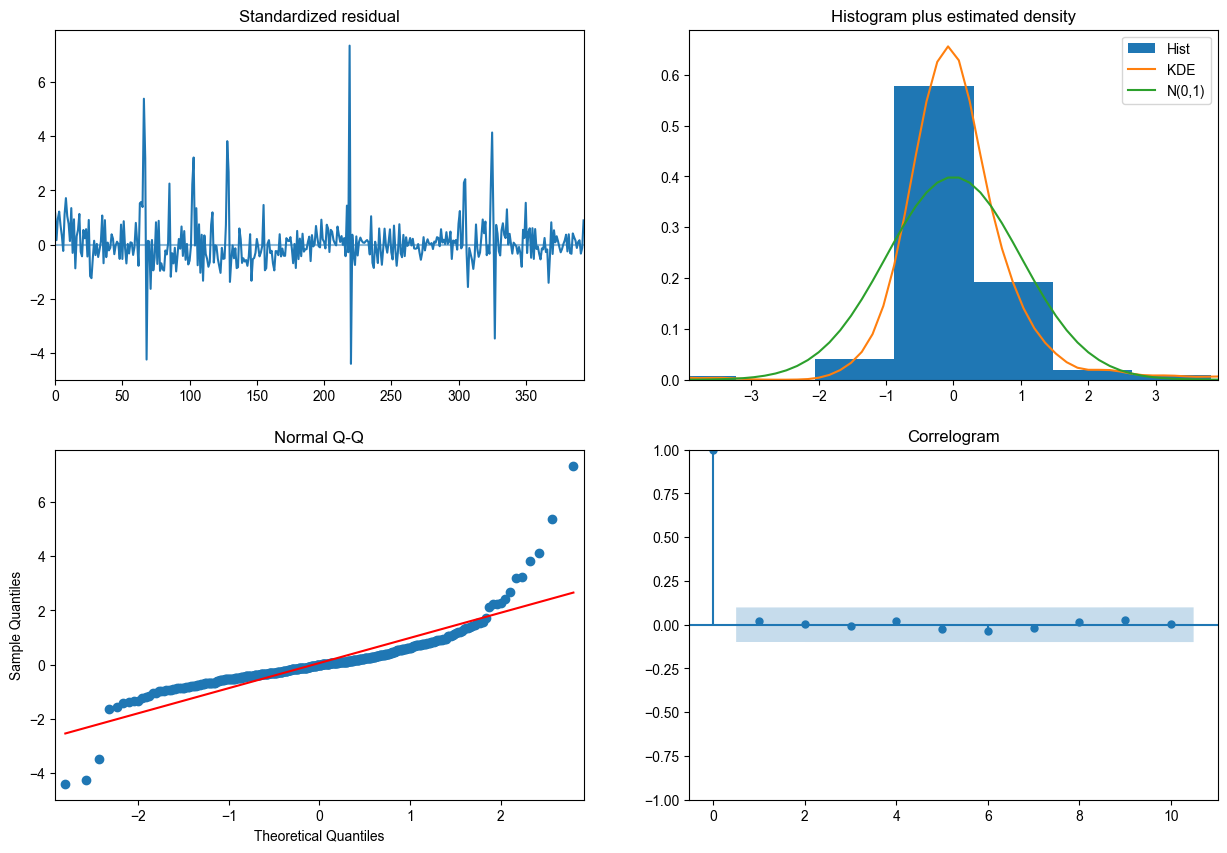

In [14]:
# 殘差診斷(原本 Auto-ARIMA 模型的)，這個只是拿來分析用，實際跑的是拿 ARIMA 的
auto_model.plot_diagnostics(figsize = (15, 10))
plt.show()

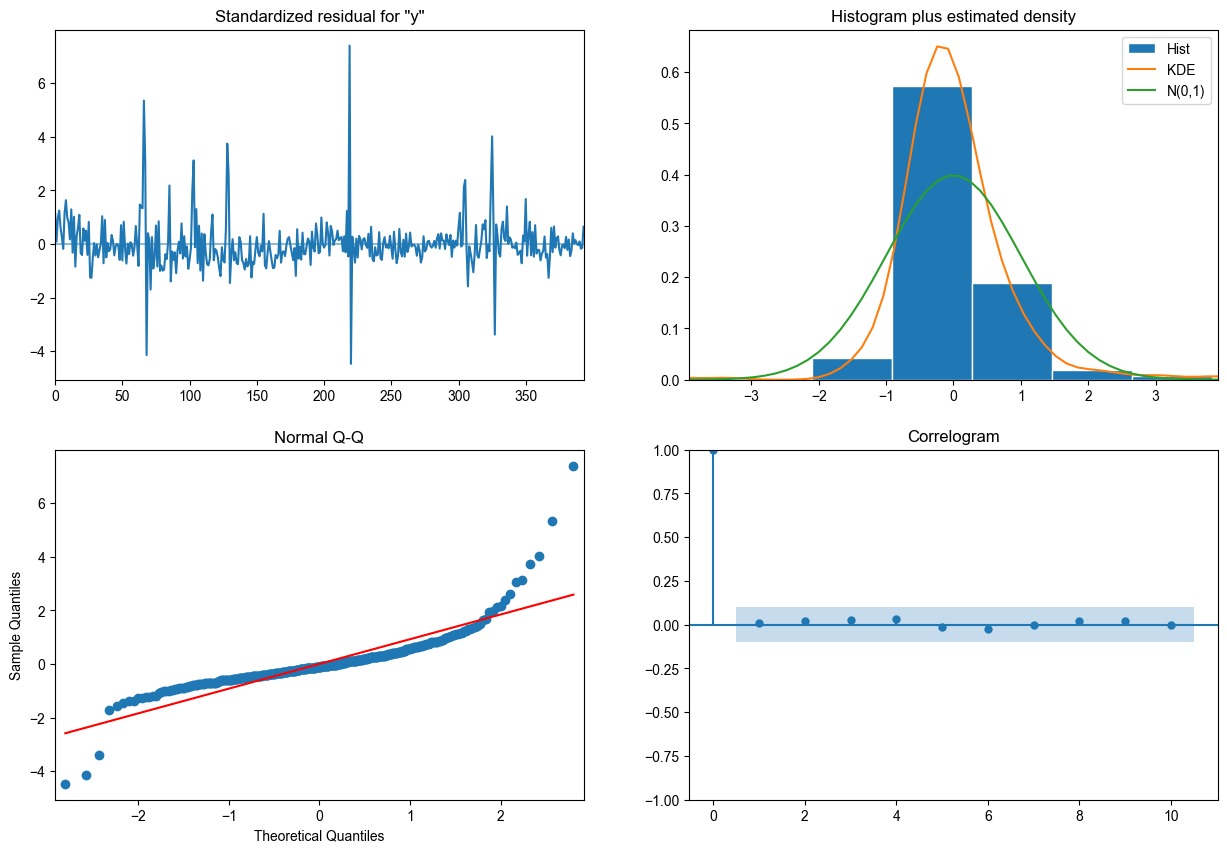

In [15]:
# 殘差診斷(原本 ARIMA 模型的)
model_summary_fit.plot_diagnostics(figsize = (15, 10))
plt.show()

## 白噪音檢定
藉由 Ljung-Box 定觀察 ARIMA 模型的殘差項是否為隨機變動，若檢定結果呈現白噪音(隨機)，則可以知道ARIMA模型的配適程度良好，便直接做預測；然而，若檢定結果呈現誤差項目並非白噪音，則需要用 `GARCH 模型找出誤差項中的變異數解釋變量`。

+ lb_stat : 這是 Ljung-Box 檢驗的檢驗統計量，用於檢查序列的自相關性，值越高表示序列具有較強的自相關性。
+ lb_pvalue : 這是對應於 Ljung-Box 統計量的 p 值，`用於檢驗零假設，即序列是白噪聲`，p 值小於 0.05（或選擇的顯著性水平）表示可以拒絕零假設，即序列可能具有顯著的自相關性，不是白噪聲。

In [16]:
lb_pvalue, white_noise_arima = arima.arima_acorr_ljungbox(arima_resid, training_window)

print('↓↓↓↓ Ljung-Box 檢驗結果 ↓↓↓↓') 
white_noise_arima

# Ljung-Box 檢驗
 H0: 誤差項為白噪音，資料是隨機的
 H1: 誤差項不是白噪音

誤差項 (P-value >= 0.05)，不能拒絕原假設(H0 成立)，殘差 "是" 白噪聲，代表殘差項目中沒有其他解釋變量可以提取，可直接使用 ARIMA 檢驗，理論上就可以停了
↓↓↓↓ Ljung-Box 檢驗結果 ↓↓↓↓


,lb_stat,lb_pvalue
14,3.254261,0.998532


## ARCH Effect 檢定

In [17]:
arch_test_result = arima.arima_het_arch(arima_resid, training_window)

# ARCH Effect 檢定
 H0: 資料中不存在 ARCH 效應
 H1: 資料中存在 ARCH 效應

殘差的方差 (P-value <= 0.05)，拒絕原假設，存在顯著的 ARCH 效應，需要進一步使用 GARCH
↓↓↓↓ ARCH 檢驗結果 ↓↓↓↓
ARCH 檢驗統計量: 39.53516734934491
p 值: 0.0003013573955488022
F 統計量: 3.026848252892526
F 統計量的 p 值: 0.00019499755566690008


# 顯示預測圖表

# 顯示預測圖表


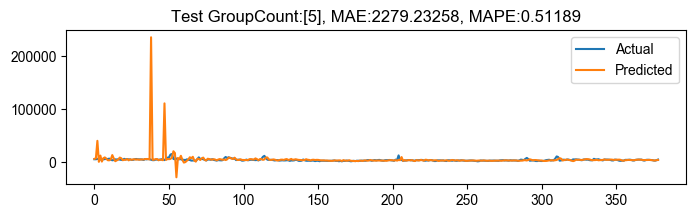

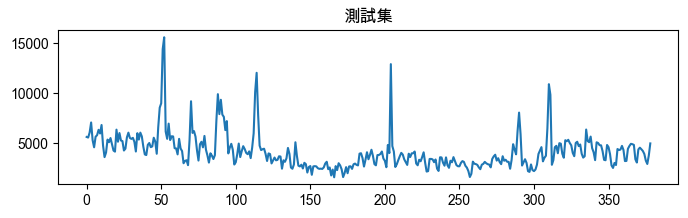

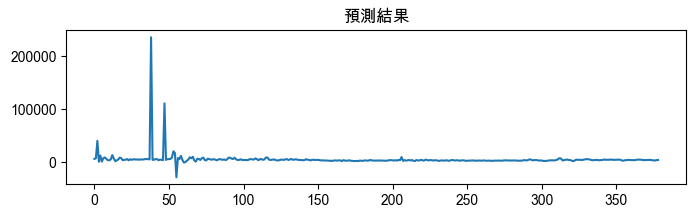

In [18]:
title = f'Test {fieldName}:{predict_types}, MAE:{round(mae, 5)}, MAPE:{round(mape, 5)}'

arima.show_predict_chart(
    eval_df,   
    actual = test_acts,
    predict = predictions,
    title = title
)

plt.figure(figsize=(8, 2))
plt.plot(test_acts, label='Actual')
plt.title('測試集')
plt.show()

plt.figure(figsize=(8, 2))
plt.plot(predictions)
plt.title('預測結果')
plt.show()

# 儲存結果

In [19]:
arima.save_json_file(
    result_file_name, 
    label = fieldName,
    predicteds = predict_types,
    best_p = best_p,
    best_d = best_d,
    best_q = best_q,
    best_aic = best_aic,
    best_ar_pvalue = best_ar_pvalue,
    best_ma_pvalue = best_ma_pvalue,
    mae_test = mae,
    mape_test = mape, 
    mse_test = mse,
    rmse_test = rmse,
    r_square_test = r_square,
    lb_pvalue = lb_pvalue,
    arch_pvalue = arch_test_result[1]
) 

# 儲存評估結果到 JSON 檔案
{'label': 'GroupCount', 'predicteds': [5], 'arima_p': 10, 'arima_d': 1, 'arima_q': 14, 'aic': 6718.916004231252, 'test_mae': 2279.23258, 'test_mape': 0.51189, 'test_mse': 181818748.66621, 'test_rmse': 13484.01827, 'test_r_square': -57.85793, 'ar_pvalue': '0.0016837876', 'ma_pvalue': '0.6201231293', 'lb_pvalue': 0.9985317583493403, 'arch_pvalue': 0.0003013573955488022}
儲存評估結果到 ARIMA/_Model/GroupCount_data5.result.json
